# Lab 07: Credit Card Fraud Detection

---
author: Katherine Mei
date: October 25, 2024
embed-resources: true
---

## Introduction

In this report, we will use credit card transaction data to develop a model that detects fraud. Our objective is to create a model that can accurately identify fraudulent transactions, achieving an optimal balance between false positives and false negatives. For this purpose, we will use modified data from the Kaggle dataset Credit Card Fraud Detection.

## Methods

In [1]:
# imports
import pandas as pd
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, fbeta_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

### Data

In [2]:
# load data
fraud = pd.read_parquet("https://cs307.org/lab-07/data/fraud.parquet")

fraud_train, fraud_test = train_test_split(
    fraud,
    test_size=0.20,
    random_state=42,
    stratify=fraud["Fraud"],
)

fraud_train

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
57638,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,...,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
27686,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,...,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
13321,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,...,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
28308,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,...,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
54252,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,...,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49499,-0.033583,-0.487672,1.435406,-2.759369,-1.785638,0.402364,-2.306038,-2.287179,0.129717,-1.036412,...,-1.286823,0.824100,0.018890,0.000018,0.301618,0.081215,0.163422,0.252456,10.00,0
29250,-0.731245,1.151677,0.912393,-0.653540,0.700577,-0.461372,1.093273,-0.126254,-0.339171,-0.467356,...,-0.368185,-0.991854,-0.376461,-0.661608,0.554237,0.450650,0.076395,0.096252,6.99,0
31586,2.135923,-0.714182,-1.842502,-0.587267,0.090754,-0.465733,-0.024834,-0.328747,-0.659832,0.853241,...,-0.537267,-1.081138,0.196589,0.087797,-0.111583,0.479888,-0.082523,-0.053305,64.90,0
14898,-0.335632,0.939736,-2.961515,-1.224739,4.446891,2.352092,0.789725,0.609460,-0.746845,-1.580751,...,-0.002116,0.009686,-0.428325,0.536043,0.278736,0.680976,-0.069295,0.051891,0.76,0


## Data Dictionary

Each observation in the train, test, and (hidden) production data contains information about a particular credit card transaction.

### Response

- **Fraud** 
  - `int64`: status of the transaction. 1 indicates a fraudulent transaction and 0 indicates not fraud, a genuine transaction.

### Features

- **Amount**
    - `float64`: amount (in dollars) of the transaction

- **PC01 - PC28**
    - `float64`: the 28 principal components that encode information such as location and type of purchase while preserving customer privacy

In [3]:
# summary statistics
fraud_train.shape

(54276, 30)

In [4]:
# counts and proportions
type_counts = fraud_train['Fraud'].value_counts()
type_counts

Fraud
0    53961
1      315
Name: count, dtype: int64

In [5]:
type_proportions = type_counts / len(fraud_train)
type_proportions

Fraud
0    0.994196
1    0.005804
Name: count, dtype: float64

In [6]:
# amount calculations

mean_all = fraud_train['Amount'].mean()
std_dev_all = fraud_train['Amount'].std()
median_all = fraud_train['Amount'].median()
max_all = fraud_train['Amount'].max()

no_fraud_df = fraud_train[fraud_train['Fraud'] == 0]
fraud_df = fraud_train[fraud_train['Fraud'] == 1]

mean_no_fraud = no_fraud_df['Amount'].mean()
std_dev_no_fraud = no_fraud_df['Amount'].std()
median_no_fraud = no_fraud_df['Amount'].median()
max_no_fraud = no_fraud_df['Amount'].max()

mean_fraud = fraud_df['Amount'].mean()
std_dev_fraud = fraud_df['Amount'].std()
median_fraud = fraud_df['Amount'].median()
max_fraud = fraud_df['Amount'].max()

print("Statistics for All Transactions (None):")
print("Mean:", mean_all)
print("Standard Deviation:", std_dev_all)
print("Median:", median_all)
print("Maximum:", max_all)

print("Statistics for Non-Fraudulent Transactions:")
print("Mean:", mean_no_fraud)
print("Standard Deviation:", std_dev_no_fraud)
print("Median:", median_no_fraud)
print("Maximum:", max_no_fraud)

print("Statistics for Fraudulent Transactions:")
print("Mean:", mean_fraud)
print("Standard Deviation:", std_dev_fraud)
print("Median:", median_fraud)
print("Maximum:", max_fraud)

Statistics for All Transactions (None):
Mean: 88.19790275628269
Standard Deviation: 241.53561659607715
Median: 21.69
Maximum: 10199.44
Statistics for Non-Fraudulent Transactions:
Mean: 88.06510368599545
Standard Deviation: 241.45114392494762
Median: 21.8
Maximum: 10199.44
Statistics for Fraudulent Transactions:
Mean: 110.94701587301587
Standard Deviation: 254.97895988379767
Median: 6.99
Maximum: 2125.87


Text(37.722222222222214, 0.5, 'Principal Component 2')

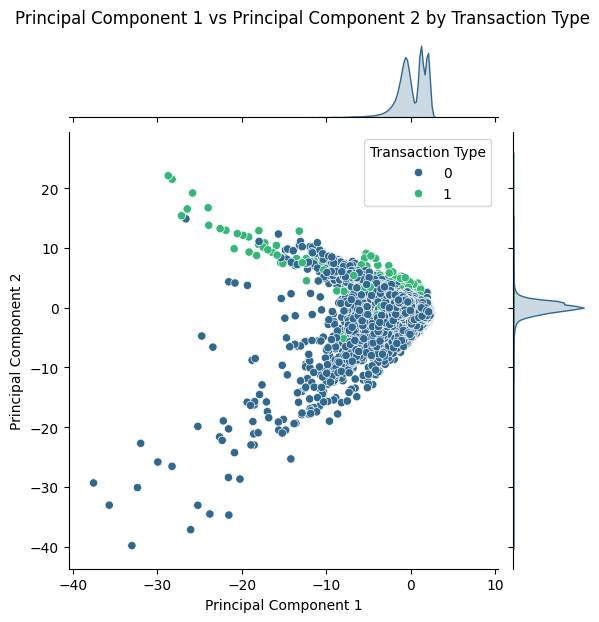

In [7]:
# visualizations
v = sns.jointplot(
    data=fraud_train, 
    x='PC01', 
    y='PC02', 
    hue='Fraud', 
    palette='viridis', 
    kind='scatter'
)

v.ax_joint.legend(title='Transaction Type')
plt.suptitle('Principal Component 1 vs Principal Component 2 by Transaction Type', y=1.03)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

The jointplot visualization shows the relationships between the first two principal components, PC1 and PC2, from the credit card transaction data. The points are categorized as normal (0 and blue) or fraudulent (1 and green).

Looking at the visualization, most of the normal transactions (0) are clustered around the center and lower ends of the PC1 axis. Fraudulent transactions (1) are clustered around the higher values of PC1, mostly from about -10 to 10 on the PC1 axis, and from 0 to 20 on the PC2 axis. Comparing the locations of normal and fraudulent transactions, there appears to be some separation between normal and fradulent transactions, especially along the PC1 axis. This suggests that PC1 may be capturing variances in the data that are significant for distinguishing between the two types of transactions. Additionally, there seems to be outliers in the data, particularly among the normal transactions. 

Looking at the marginal distributions, the marginal distribution for PC1 at the top shows two peaks, showing that there are two groups of densities in PC1 values. The right-side marginal distribution for PC2 shows a skewed distribution. 


### Models

In [8]:
# process data for ML

# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [9]:
# train models
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# pipeline for numeric
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

# combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# full pipeline
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("Classifier", RandomForestClassifier()) 
    ]
)

# train models
param_grid = {
        "Classifier": [RandomForestClassifier()],
        "Classifier__n_estimators": [50, 100],
        "Classifier__max_depth": [5, 10],   
        "Classifier__class_weight": ['balanced', {0: 1, 1: 2}]
}

# scoring
scoring = make_scorer(fbeta_score, beta=5)

#gridsearch
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    verbose=2,
    scoring=scoring,
    refit='accuracy' 
)

mod = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END Classifier=RandomForestClassifier(), Classifier__class_weight=balanced, Classifier__max_depth=5, Classifier__n_estimators=50; total time=   3.6s
[CV] END Classifier=RandomForestClassifier(), Classifier__class_weight=balanced, Classifier__max_depth=5, Classifier__n_estimators=50; total time=   3.6s
[CV] END Classifier=RandomForestClassifier(), Classifier__class_weight=balanced, Classifier__max_depth=5, Classifier__n_estimators=50; total time=   3.6s
[CV] END Classifier=RandomForestClassifier(), Classifier__class_weight=balanced, Classifier__max_depth=5, Classifier__n_estimators=50; total time=   3.6s
[CV] END Classifier=RandomForestClassifier(), Classifier__class_weight=balanced, Classifier__max_depth=5, Classifier__n_estimators=50; total time=   3.6s
[CV] END Classifier=RandomForestClassifier(), Classifier__class_weight=balanced, Classifier__max_depth=5, Classifier__n_estimators=100; total time=   7.0s
[CV] END Classi

The first part of the modeling process involves preparing the data to ensure it is ready for analysis. All numeric features from the dataset are selected and these features undergo two main transformations: imputation and standardization. Imputation replaces missing values with the mean of the feature, and standardization adjusts the feature to help the data become normalized across all features.

The second part involves the construction of the model. The model combines the preprocessing steps mentioned earlier and classifies them with a Random Forest Classifier. In order to optimize the model, a grid search is used, where it tests different instances of the Random Forest Classifier. The different instances include different parameters, such as the number of decision trees in the forest, the maximum depth of the trees, and the class weights.

The third part involves evaluating the model. To do so, a scoring function that prioritizes recall over precision is used, where a beta value of 5 is set in the F-beta score calculation. Integrating the scoring function into the grid search, then the grid search performs a 5-fold cross-validation to validate the model's performance. 

## Results

In [10]:
print("Best parameters:", mod.best_params_)

Best parameters: {'Classifier': RandomForestClassifier(), 'Classifier__class_weight': 'balanced', 'Classifier__max_depth': 5, 'Classifier__n_estimators': 100}


The selected model is a Random Forest Classifier, with a class weight of "balanced" to address class imbalances. It has a maximum depth of 5 levels for each tree and consists of 100 decision trees in the forest.

In [11]:
# report model metrics
y_pred = mod.predict(X_test)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8271604938271605
Recall: 0.8481012658227848


The selected model and its parameters yields a precision score of 0.817 and a recall score of 0.848.

## Discussion

The selected Random Forest Classifier and its parameters have a precision score of 0.82 and a recall score of 0.85. The precision score measures the accuracy of positive predictions. In this case, the precision score tells us that there is a high percentage of positive predictions that were correct. A high precision score indicates a low rate of false positives. On the other hand, the recall score measures the model's ability to find all true positives in the dataset. A high recall score indicates a low rate of false negatives. 

In the context of fraudulent activity detection in credit card transactions, recall is more important than precision. The reason why recall becomes more important is because, as mentioned earlier, recall indicates the rate of false negatives. A false negative is when a test incorrectly identifies a condition as present when it is not. For example, if a fraud detection system fails to flag a transaction that is fraudulent and allows it to process through, this would be a false negative. Undetected fraudulent transactions can greatly effect both the cardholder and the banking insitution with the credit card. The loss on both sides can reach extremes, which is why it is important to identify as many fraud cases as possible. The reason a false positive is not as crucial is because a false positive indicate a transaction flagged as fraudulent, but is not. A false positive has less serious consequences than a false negative. From a monetary perspective, a false positive would be less expensive on both parties than a false negative. In this scenario, the recall value is not high enough. The recall score is 85%, leaving still a 15% chance of false negatives taking place. 

Another point to consider is trust between cardholders and their banking institutions. In recent years, there has been an observed trend of lower trust between younger generations and banking insitutions (Smith). The younger generations are the future customers of banking insitutions. Therefore, it is essential these banking institutions gain and retain the trust of the younger generations. Fraudulent activity detection is a prime way for banking institutions to build that trust. Therefore, a model that prioritizes recall, which relates to a low rate of false negatives, is more important than precision, which focuses more on false positives.

Taking all of this into account, it would not be adequate to use this model to identify fraudulent transactions. The recall score of 0.85 is too low, leading to an increased risk of missed fraudulent activity. If the model's recall score can be significantly improved, at least to 0.95, then the model may be useful in a practical setting.

References:
Smith, Kevin. “From Skepticism to Trust: How Banks Can Win Over Younger Generations.” Mighty Roar, 18 September 2023, https://www.mightyroar.com/blog/how-banks-can-win-over-younger-generations. Accessed 4 November 2024.

### Conclusion

Taking practicality reasons into consideration, the developed Random Forest Classifier Model should not be used to detect fraudulent transactions.

In [12]:
dump(mod, "credit-fraud.joblib", compress = 9)

['credit-fraud.joblib']